# FEATURE ENGINEERING
 

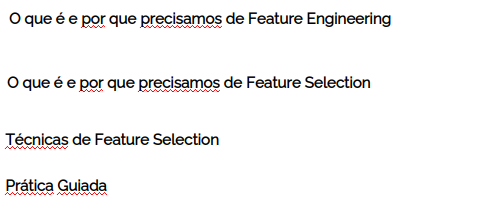

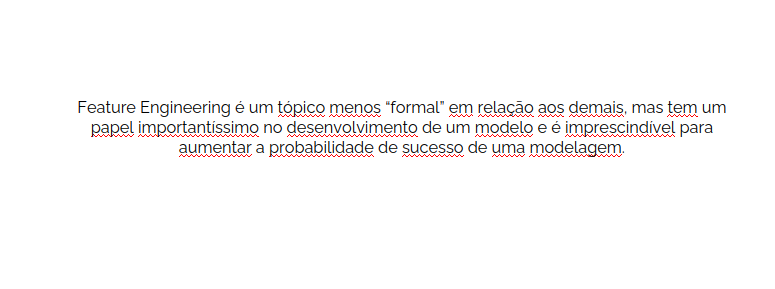

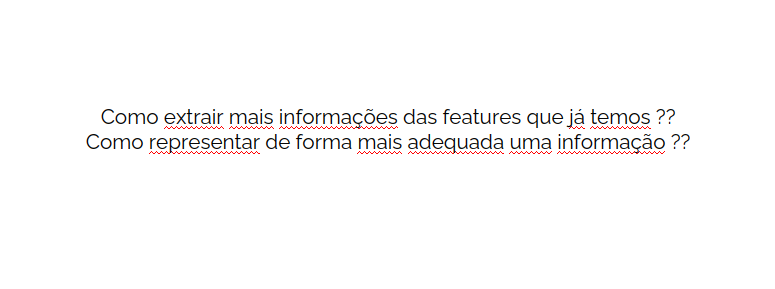

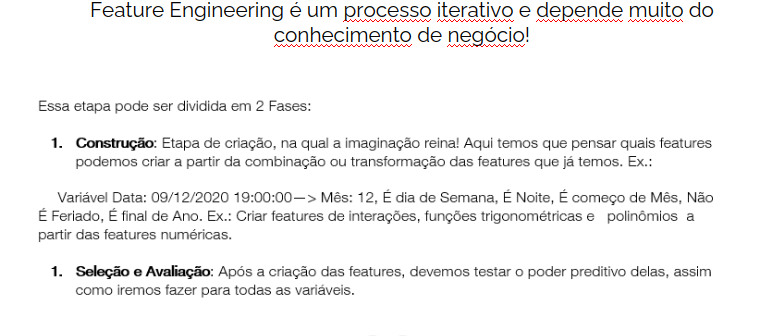

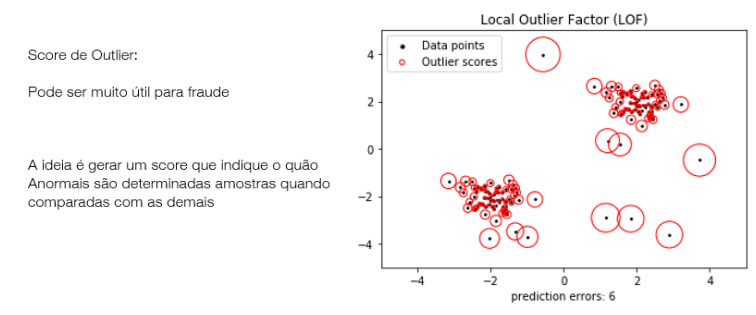

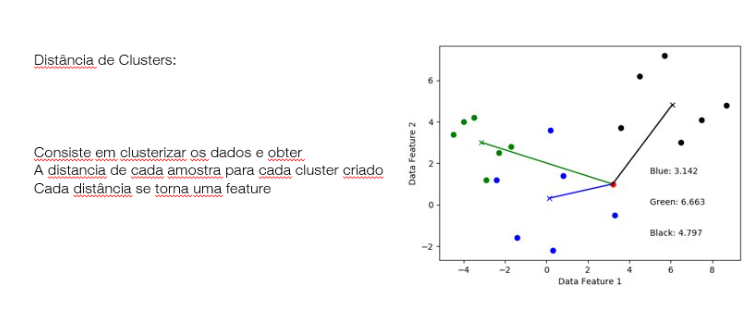

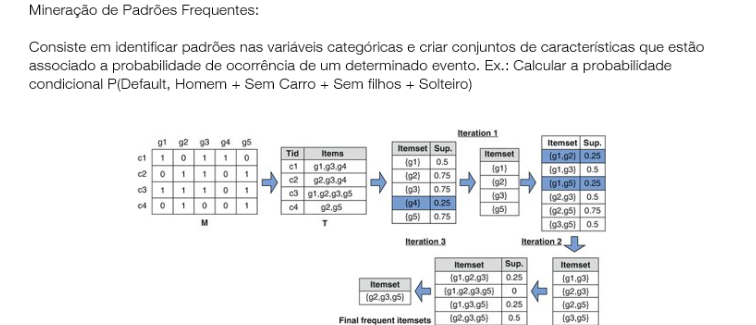

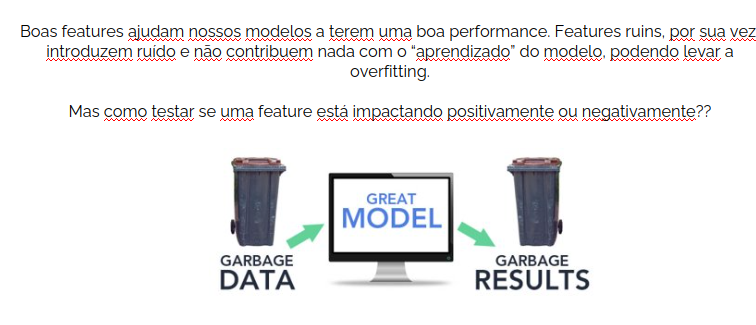

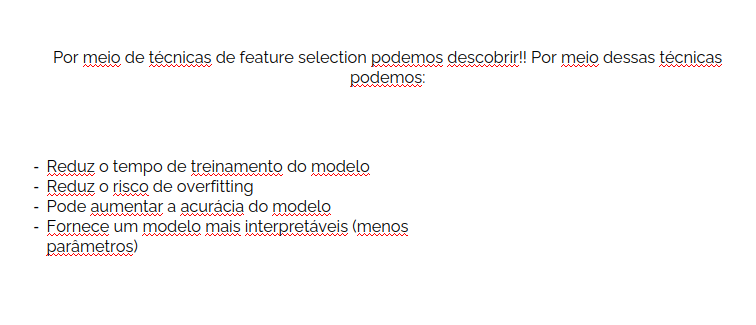

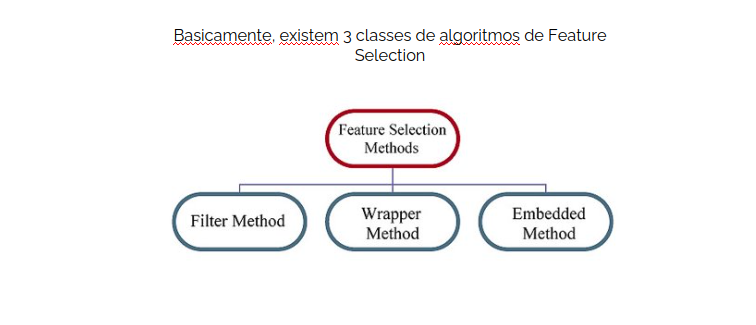

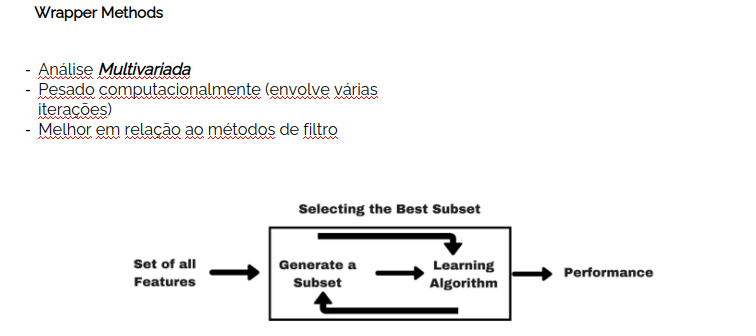

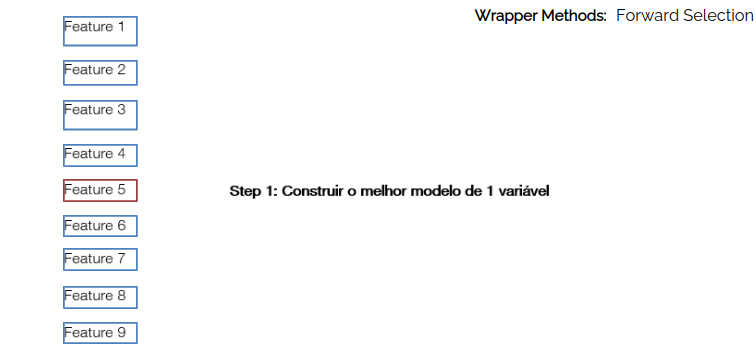

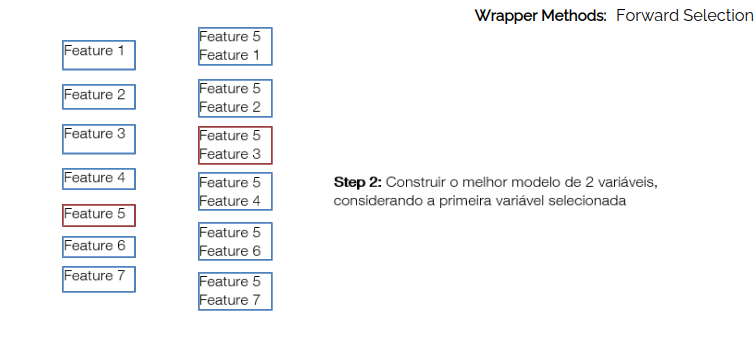

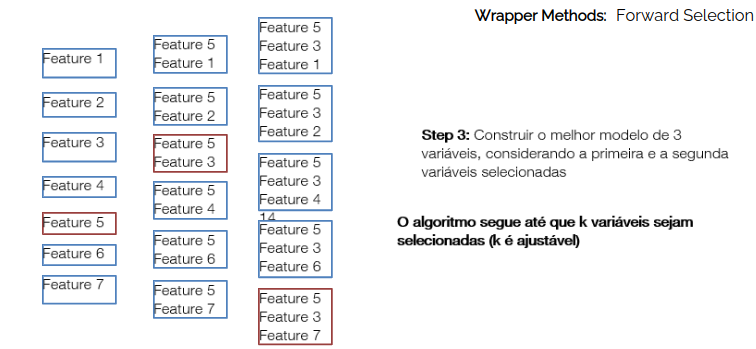

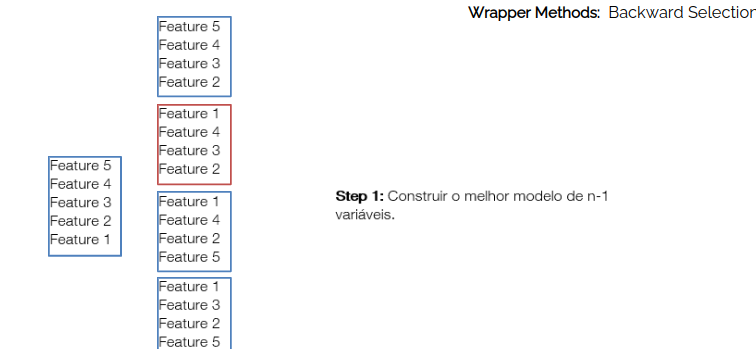

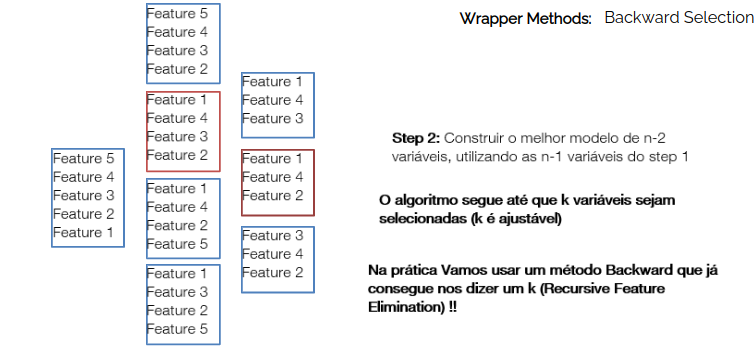

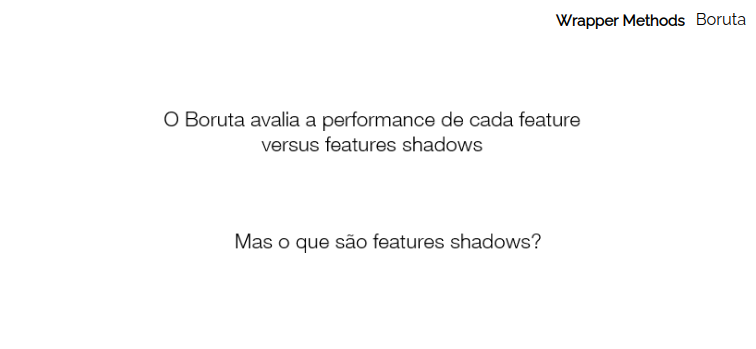

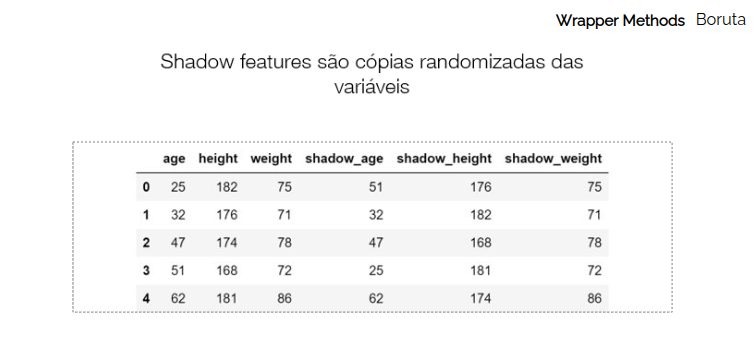

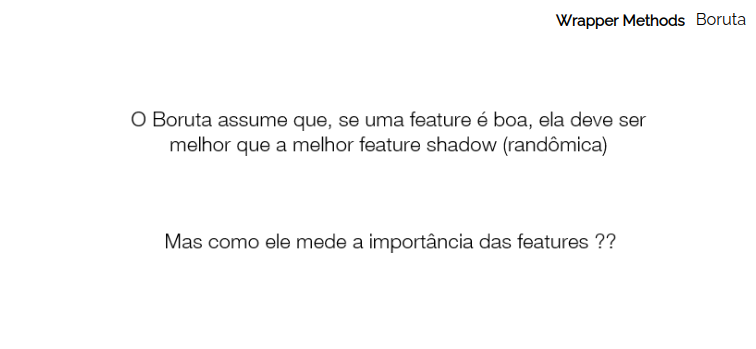

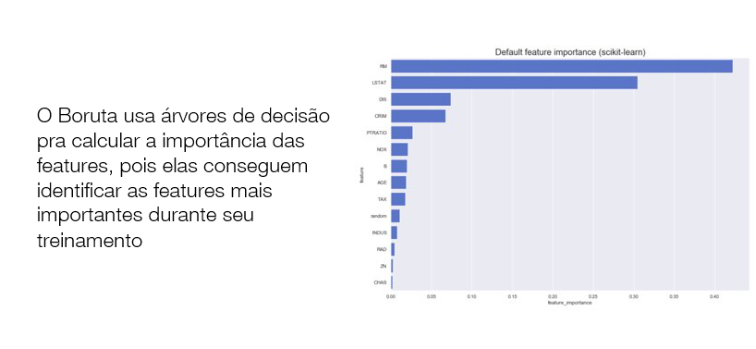

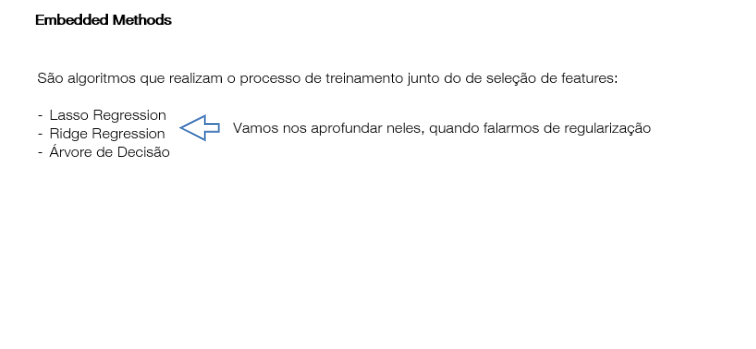

# Setup

In [ ]:
# libs
#!pip install pycaret --user
#!pip install  boruta
from boruta import BorutaPy
#from pycaret.datasets import get_data
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, f_classif, chi2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# dados
df_credit = get_data('credit')

## Boruta

Para ilustrar o funcionamento dos métodos, vamos criar um dataset. Isso mesmo! Datasets sintéticos são legais para demonstrar esse tipo de coisa. Na prática, não conhecemos a verdadeira relação funcional entre as variáveis que estamos modelando, certo? Tampouco sabemos se as features que ali estão ajudam ou não o nosso modelo. A ideia de criar um dataset sintético é justamente ter a certeza de quais features têm relação com o target e quais não têm!. Dessa formaa, podemos checar a validade desse método.

vamos criar uma lista de variáveis.

In [ ]:
variaveis_dataset = [
   'linear',            # 1
   'quadrado',  # 2
   'seno',     # 3
   'interacao1',     # 4
   'interacao2',     # 5
   'interacao3',     # 6
   'aleatoria_1',           # 7
   'aleatoria_2',           # 8
   'aleatoria_3',           # 9
   'aleatoria_4']           # 10

Cada variavel será uma distribuição normal e o dataset é composto por 20000 linhas.

In [ ]:
np.random.seed(0)
X = pd.DataFrame(np.random.normal(size = (20000, len(variaveis_dataset))), columns = variaveis_dataset)

Y será uma função de algumas colunas de X (todas, menos as aleatorias)

In [ ]:
y = X['linear'] + X['quadrado']**2 + np.sin(3*X['seno']) + (X['interacao1'] * X['interacao2'] * X['interacao3'])

Assim como a análise exploratória e os testes de hipótese, vamos aplicar a seleção de features sempre nos dados de treino.

In [ ]:
# dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.85, random_state = 0)

In [ ]:
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 50, max_iter=100, random_state = 0)
boruta_selector.fit(np.array(X_train), np.array(y_train))

In [ ]:
# Terceiro filtro com as features selecionadas pelo boruta
cols_drop_boruta= [not x for x in boruta_selector.support_.tolist()] # apenas invertendo o vetor de true/false
cols_drop_boruta= X_train.loc[:,cols_drop_boruta].columns.tolist()

In [ ]:
cols_drop_boruta

## Recursive Feature Elimination

In [ ]:
# 1a Selação (Random Forest)
rfecv_RFC = RFECV(estimator=forest, scoring='neg_mean_squared_error')
rfecv_RFC.fit(X_train,y_train)

In [ ]:
print(rfecv_RFC.n_features_) # Número de features selecionadas como as mais importantes 
print(rfecv_RFC.support_) # Vetor de booleans. True se a variável deve ser mantida e False caso contrário
mask_RFC = rfecv_RFC.support_

In [ ]:
cols_drop_RFE= [not x for x in mask_RFC] # apenas invertendo o vetor de true/false
cols_drop_RFE= X_train.loc[:,cols_drop_RFE].columns.tolist()

In [ ]:
cols_drop_RFE

# Filter

O dataset credit se refere a clientes e seus empréstimos. A coluna target indica se o cliente honrou com seus compromissos ou não.

In [ ]:
X = df_credit.drop('default.payment.next.month',axis=1)

In [ ]:
Y = df_credit['default.payment.next.month']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=123)

In [ ]:
X_train_num = X_train.filter(regex='AGE|BILL|PAY|LIMIT_BAL')
X_train_cat = X_train.loc[:,['SEX', 'EDUCATION', 'MARRIAGE']]

In [ ]:
X_train.dtypes

AS colunas com Sufixo PAY e BILL e a coluna LIMIT_BAL são numéricas. Assim, podemos testar as médias dessas features em relação aos grupos da variável target.

## ANOVA

In [ ]:
selected_anova = f_classif(X_train_num, y_train)

In [ ]:
selected_anova

In [ ]:
p_values_num = pd.Series(selected_anova[1])

In [ ]:
p_values_num.index = X_num.columns 
p_values_num.sort_values(ascending=True, inplace=True)

In [ ]:
p_values_num

In [ ]:
p_values_num = p_values_num[p_values_num<0.05]

In [ ]:
p_values_num.index

In [ ]:
X_train_num_anova = X_train_num.loc[:,p_values_num.index]

In [ ]:
X_train_num_anova

## Chi2

In [ ]:
selected_chi2 = chi2(X_train_cat, y_train)

In [ ]:
selected_chi2

In [ ]:
p_values_cat = pd.Series(selected_chi2[1])

In [ ]:
p_values_cat.index = X_train_cat.columns 



In [ ]:
p_values_cat = p_values_cat[p_values_cat<0.05]

In [ ]:
X_train_cat_chi2 = X_train_cat[p_values_cat.index]

In [ ]:
p_values_cat

In [ ]:
X_train_filtered = pd.concat([X_train_num_anova, X_train_cat_chi2], axis=1)

In [ ]:
X_train_filtered

# Prática Independente

Aplique o RFECV e o Boruta no dataset filtrado.